# 1. Import Libraries & Load Cleaned Data

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from datetime import datetime

# Set style
sns.set(style='whitegrid')

# Load data
df_price = pd.read_csv(r"C:\Users\hp\Desktop\10 Acadamy\VS code\brent-oil-change-point-analysis\data\processed\brent_oil_prices_processed.csv", parse_dates=["Date"])
df_events = pd.read_csv(r"C:\Users\hp\Desktop\10 Acadamy\VS code\brent-oil-change-point-analysis\data\processed\events_processed.csv", parse_dates=["EventDate"])

# 2. Visualize Oil Prices with Events

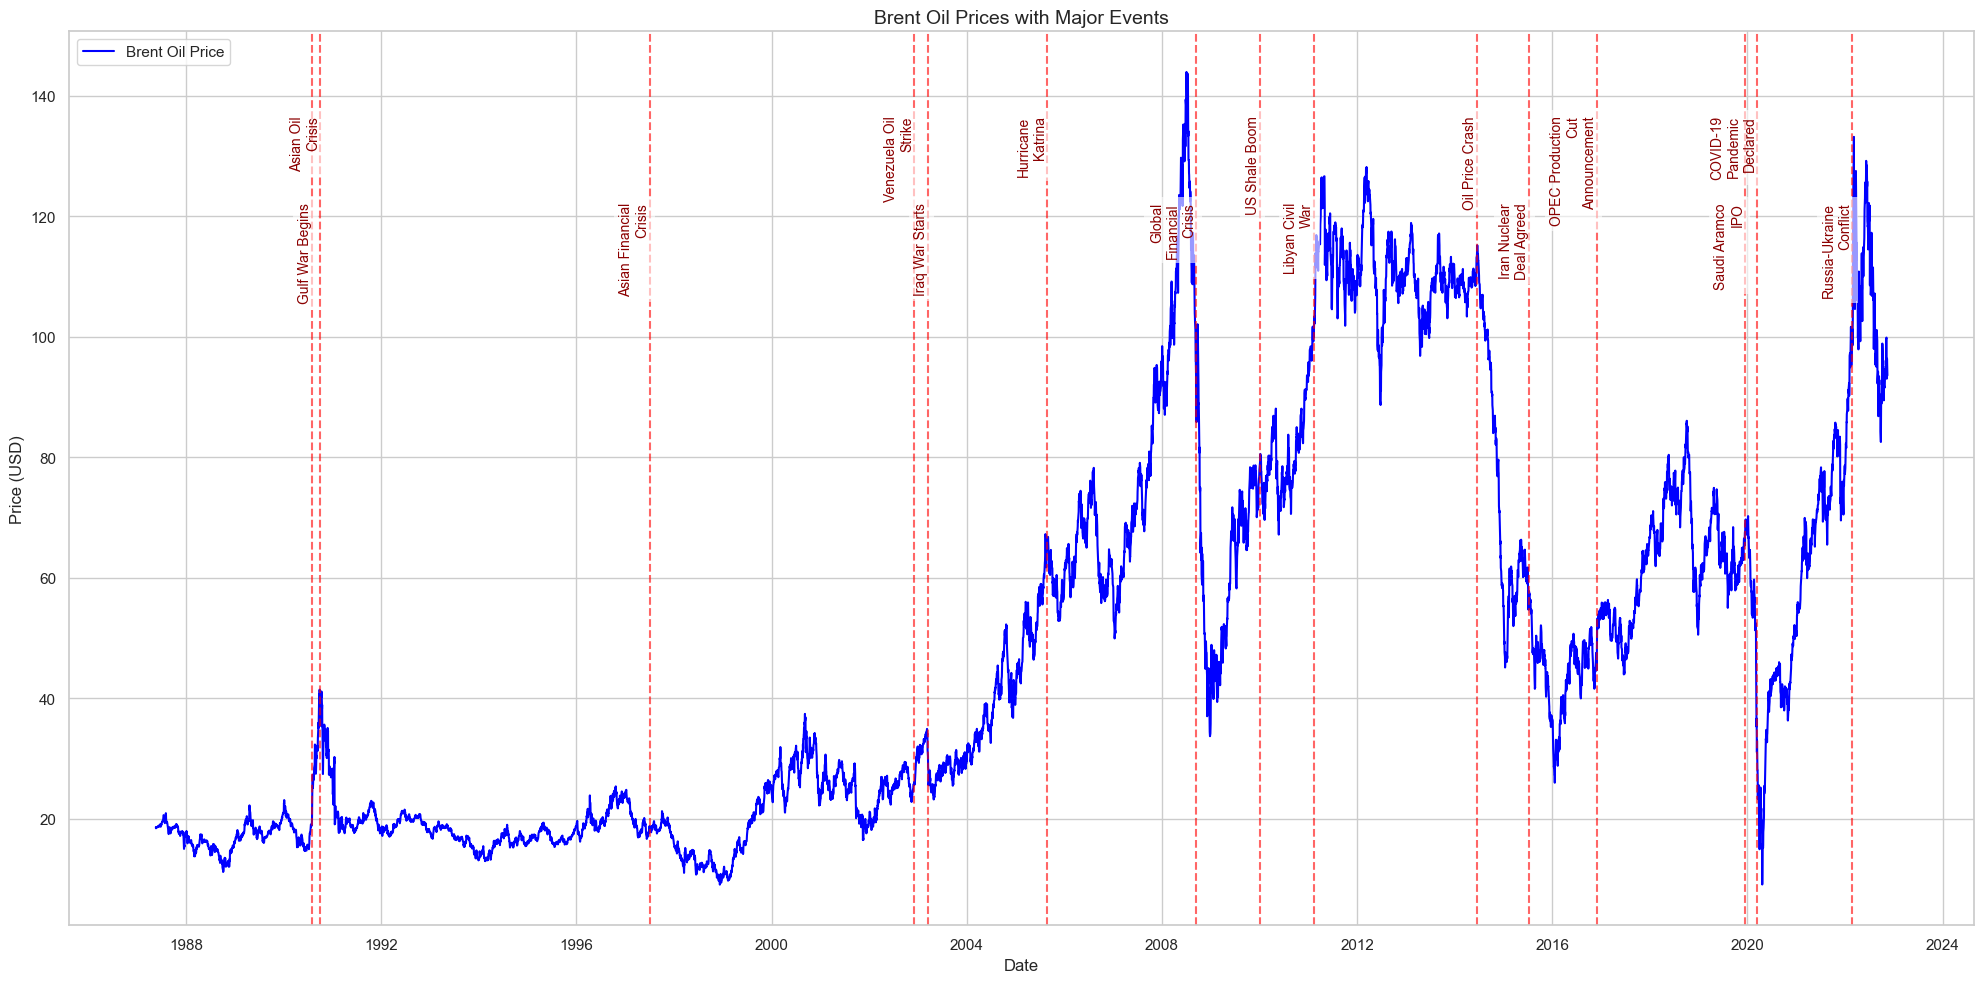

In [42]:

plt.figure(figsize=(20, 10))  
plt.plot(df_price["Date"], df_price["Price"], label="Brent Oil Price", color='blue')

max_price = df_price["Price"].max()

for i, row in df_events.iterrows():
    # Alternate vertical positions to reduce overlap
    y_pos = max_price * (0.85 if i % 2 == 0 else 0.95)

    # Draw the vertical event line
    plt.axvline(x=row["EventDate"], color="red", linestyle="--", alpha=0.6)

    # Wrap long event names and display them with larger font
    label = "\n".join(textwrap.wrap(row["EventName"], width=15))  # wrap after 15 chars
    plt.text(
        row["EventDate"],
        y_pos,
        label,
        rotation=90,
        fontsize=10,           
        color='darkred',
        ha='right',
        va='top',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')  
    )

plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.title("Brent Oil Prices with Major Events", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


# 3. Compare Events with Change Points

In [43]:
# Assume change point index is 3000
change_point_date = df_price["Date"].iloc[3000]
print("Detected change point date:", change_point_date)

# Compare with nearby events
df_events[
    (df_events["EventDate"] >= change_point_date - pd.Timedelta(days=30)) &
    (df_events["EventDate"] <= change_point_date + pd.Timedelta(days=30))
]


Detected change point date: 1999-03-15 00:00:00


,EventName,EventDate,Description,ExpectedImpact


# 4. Quantify Impact of Events

In [44]:
window = 30  # days before and after
for _, event in df_events.iterrows():
    date = event["EventDate"]
    pre_event = df_price[(df_price["Date"] >= date - pd.Timedelta(days=window)) &
                         (df_price["Date"] < date)]["Price"]
    post_event = df_price[(df_price["Date"] > date) &
                          (df_price["Date"] <= date + pd.Timedelta(days=window))]["Price"]
    
    print(f"{event['EventName']} ({date.date()}):")
    print(f"  Mean before: {pre_event.mean():.2f}, Mean after: {post_event.mean():.2f}")
    print(f"  Change: {((post_event.mean() - pre_event.mean()) / pre_event.mean()) * 100:.2f}%\n")


Gulf War Begins (1990-08-02):
  Mean before: 17.38, Mean after: 27.75
  Change: 59.69%

Asian Oil Crisis (1990-10-01):
  Mean before: 34.90, Mean after: 35.89
  Change: 2.84%

Asian Financial Crisis (1997-07-02):
  Mean before: 17.58, Mean after: 18.49
  Change: 5.17%

Venezuela Oil Strike (2002-12-02):
  Mean before: 24.26, Mean after: 28.47
  Change: 17.35%

Iraq War Starts (2003-03-20):
  Mean before: 33.05, Mean after: 25.96
  Change: -21.43%

Hurricane Katrina (2005-08-23):
  Mean before: 62.09, Mean after: 63.91
  Change: 2.94%

Global Financial Crisis (2008-09-15):
  Mean before: 106.39, Mean after: 88.25
  Change: -17.05%

US Shale Boom (2010-01-01):
  Mean before: 74.26, Mean after: 76.17
  Change: 2.58%

Libyan Civil War (2011-02-15):
  Mean before: 98.84, Mean after: 111.64
  Change: 12.95%

Oil Price Crash (2014-06-20):
  Mean before: 110.78, Mean after: 108.87
  Change: -1.72%

Iran Nuclear Deal Agreed (2015-07-14):
  Mean before: 59.53, Mean after: 52.52
  Change: -11.78%

# 5. Create Summary Table

In [45]:
summary = []
window = 30

for _, event in df_events.iterrows():
    date = event["EventDate"]
    pre = df_price[(df_price["Date"] >= date - pd.Timedelta(days=window)) &
                   (df_price["Date"] < date)]["Price"]
    post = df_price[(df_price["Date"] > date) &
                    (df_price["Date"] <= date + pd.Timedelta(days=window))]["Price"]

    summary.append({
        "Event": event["EventName"],
        "Date": date,
        "Mean Before": pre.mean(),
        "Mean After": post.mean(),
        "Percent Change": ((post.mean() - pre.mean()) / pre.mean()) * 100
    })

df_summary = pd.DataFrame(summary)
df_summary.to_csv(r"C:\Users\hp\Desktop\10 Acadamy\VS code\brent-oil-change-point-analysis\reports\event_price_impact.csv", index=False)
df_summary.head()


,Event,Date,Mean Before,Mean After,Percent Change
0,Gulf War Begins,1990-08-02,17.375000,27.746190,59.690305
1,Asian Oil Crisis,1990-10-01,34.899000,35.889545,2.838320
2,Asian Financial Crisis,1997-07-02,17.580000,18.489500,5.173493
3,Venezuela Oil Strike,2002-12-02,24.263000,28.471579,17.345666
4,Iraq War Starts,2003-03-20,33.045909,25.963810,-21.431093
